# Homework 3

## Training a ConvNet on the MNIST dataset

In [2]:
# import relevant libraries
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a dataloader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
print(f'Number of training images: {len(trainset)}')

Number of training images: 60000


In [27]:
# Define a convolutional network with three convolutioanl layers and two fully connected layers
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 2, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(2, 4, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(4, 4, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
        )
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(14*14*4, 512)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(512, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Create an instance of the ConvNet class
model = ConvNet().to('cuda')

In [ ]:
"""
Training the model
"""
# Initialize the model parameters by Xavier uniform initialization
torch.nn.init.xavier_uniform_(model.layer1[0].weight)
torch.nn.init.xavier_uniform_(model.layer2[0].weight)
torch.nn.init.xavier_uniform_(model.layer3[0].weight)
torch.nn.init.xavier_uniform_(model.fc1.weight)
torch.nn.init.xavier_uniform_(model.fc2.weight)

# Define the loss function and the optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(5):
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images.to('cuda'))
        loss = loss_func(outputs, labels.to('cuda'))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    print(f'Epoch [{epoch+1}/5], Loss: {sum(losses)/len(losses):.4f}')

# Calculate the accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        outputs = model(images.to('cuda'))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to('cuda')).sum().item()

    print(f'Accuracy of the model on the {total} train images: {100 * correct / total} %')
# Save the model
torch.save(model.state_dict(), 'mnist_cnn.pth')
print('Model saved')

In [36]:
# Load the model
model = ConvNet().to('cuda')
model.load_state_dict(torch.load('mnist_cnn.pth'))
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        outputs = model(images.to('cuda'))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to('cuda')).sum().item()

    print(f'Accuracy of the model on the {total} train images: {100 * correct / total} %')

Accuracy of the model on the 60000 train images: 98.20166666666667 %


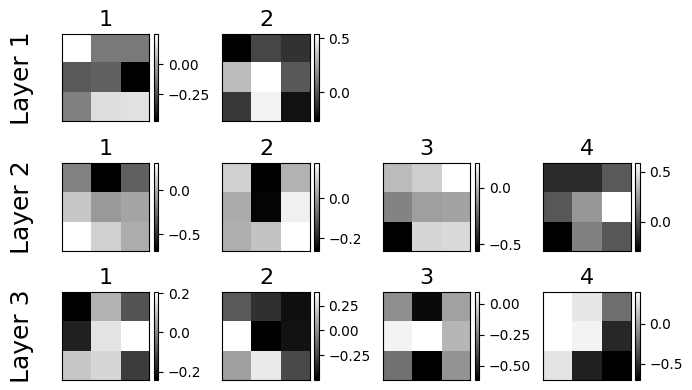

In [34]:
# Visualize the filters
import matplotlib.pyplot as plt
import numpy as np
layers = [
    {"weights": model.layer1[0].weight.data.cpu().numpy(), "title": "Layer 1", "n_filters": 2},
    {"weights": model.layer2[0].weight.data.cpu().numpy(), "title": "Layer 2", "n_filters": 4},
    {"weights": model.layer3[0].weight.data.cpu().numpy(), "title": "Layer 3", "n_filters": 4}
]
n_max_filters = max([layer["n_filters"] for layer in layers])

# Plotting all the filters
fig, ax = plt.subplots(len(layers), n_max_filters, figsize=(7, 4))

for i, layer in enumerate(layers):
    for j in range(n_max_filters):
        if j >= layer["n_filters"]:
            # If there are fewer filters than the maximum, disable the extra subplots
            ax[i,j].spines['top'].set_visible(False)
            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['bottom'].set_visible(False)
            ax[i,j].spines['left'].set_visible(False)
            ax[i,j].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
            continue
        img = ax[i, j].imshow(layer["weights"][j][0], cmap='gray')
        ax[i, j].imshow(layer["weights"][j][0], cmap='gray')  # Assuming weights are accessible like this
        ax[i, j].tick_params(left = False, right = False , labelleft = False, 
                labelbottom = False, bottom = False)
        ax[i, j].set_title(f'{j + 1}', fontsize=16)  # Title for each filter plot
        fig.colorbar(img, ax=ax[i, j], fraction=0.046, pad=0.04)  # Adjust fraction and pad as needed for layout

    # Set the layer number as Y label for the first column (or all, but only visible for the first)
    ax[i, 0].set_ylabel(layer["title"], fontsize=18, labelpad=20)
    ax[i, 0].yaxis.label.set_visible(True)  # Make sure the label is visible

plt.tight_layout()
plt.savefig('filters.eps', format='eps')  # Save the figure as an EPS file
plt.show()  # Show the plot

In [ ]:
# Define a function to find a correctly classified image for a given digit
def search_digit(digit, model, train_loader):
    for images, labels in train_loader:
        # Find the index of a '0' and '8' digit in the batch
        index = (labels == digit).nonzero(as_tuple=True)[0]

        # If there is a '0' digit in the batch
        if len(index) > 0:
            index = index[0]  # Take the first '0' digit
            image = images[index].to('cuda')
            label = labels[index]

            # Since we're evaluating, we don't need to keep track of gradients
            with torch.no_grad():
                # Unsqueeze to add the batch dimension and feed the image to the model
                predicted = model(image.unsqueeze(0))

            # Get the predicted class
            predicted = torch.argmax(predicted, 1)

            if predicted == label:
                return image, label
    return None, None


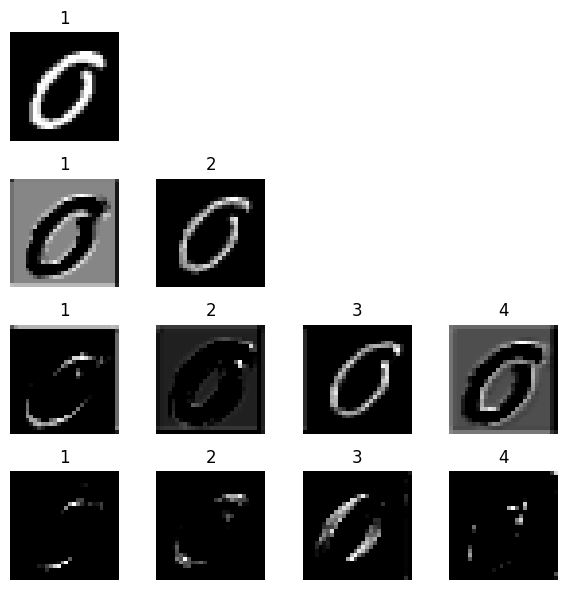

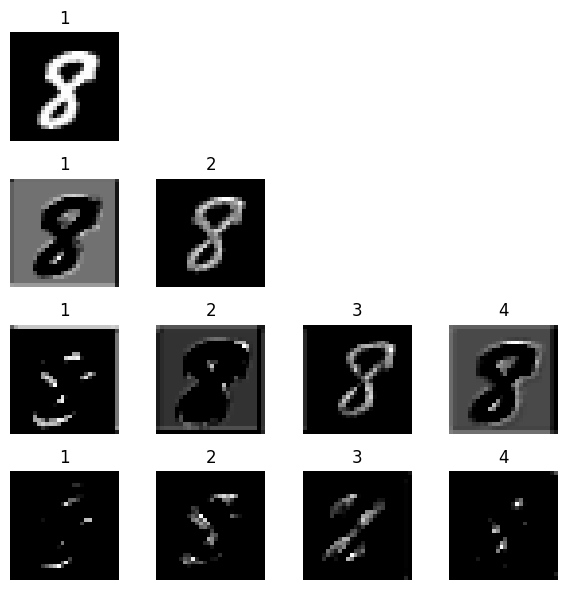

In [88]:
# Set the model to evaluation mode
model.eval()

# Find the correctly classified images and their feature maps

# Find the images
image_0, label_0 = search_digit(0, model, train_loader)
image_8, label_8 = search_digit(8, model, train_loader)

with torch.no_grad():
    # Unsqueeze to add the batch dimension and feed the image to the model
    predicted_0 = model(image_0.unsqueeze(0))
    predicted_8 = model(image_8.unsqueeze(0))

# Get the predicted class
predicted_0 = torch.argmax(predicted_0, 1)
predicted_8 = torch.argmax(predicted_8, 1)

# Calculate the feature map at each layer
feature_maps_0 = [image_0.unsqueeze(0)]
feature_maps_8 = [image_8.unsqueeze(0)]

for layer in [model.layer1, model.layer2, model.layer3]:
    feature_maps_0.append(layer(feature_maps_0[-1]))
    feature_maps_8.append(layer(feature_maps_8[-1]))
    
def plot_feature_maps(feature_maps, filename=None):
    # Number of layers
    num_layers = len(feature_maps) 

    # Create a figure with subplots in a grid of num_layers by max_num_features + 1
    # +1 to include the original image
    fig, axes = plt.subplots(num_layers, 4, figsize=(6,6))  # Adjust the size as necessary

    # Loop through each layer
    for i in range(num_layers):
        # Plot the original image only at the first layer
        if i == 0:
            axes[i, 0].imshow(feature_maps[i][0, 0].detach().cpu().numpy(), cmap='gray')
            axes[i, 0].set_title('Original Image', fontsize=12)
            for j in range(1, 4):
                axes[i,j].axis('off')  # Disable the empty subplots
        # Plot the feature maps for '0'
        for j in range(4):  # Loop through each feature map
            ax = axes[i, j]
            if j >= feature_maps[i].shape[1]:
                ax.axis('off')
                continue
            ax.imshow(feature_maps[i][0, j].detach().cpu().numpy(), cmap='gray')
            ax.set_title(f'{j+1}', fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(filename, format='eps')  # Save the figure as an EPS file

plot_feature_maps(feature_maps_0, 'feature_maps_0.eps')
plot_feature_maps(feature_maps_8, 'feature_maps_8.eps')

In [95]:
import torch.nn.functional as F

def translate_image(image, dx, dy):
    """
    Translates the image by dx to the right (dx negative) or left (dx positive)
    and dy down (dy negative) or up (dy positive) using clamp padding method.
    """
    theta = torch.tensor([[1, 0, 2*dx/28], [0, 1, 2*dy/28]], dtype=torch.float).to('cuda')
    grid = F.affine_grid(theta.unsqueeze(0), image.size(), align_corners=False)
    new_image = F.grid_sample(image, grid, padding_mode='border', align_corners=False)
    return new_image

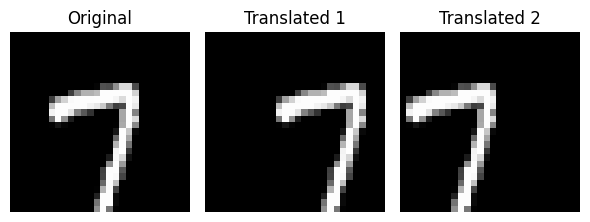

[7, 7, 7]


In [103]:
# find a '7' digit image

image, label = search_digit(7, model, train_loader)
image = image.unsqueeze(0).to('cuda')
label = label.to('cuda')

# Shift the image left and right by 5 pixels
translated_images = [image]
for dx in [-5,5]: # right and left
    translated_images.append(translate_image(image, dx, 0))

# Plot the original and translated images
fig, axes = plt.subplots(1, 3, figsize=(6,6))
for i, ax in enumerate(axes):
    ax.imshow(translated_images[i][0, 0].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Original', fontsize=12)
    else:
        ax.set_title(f'Translated {i}', fontsize=12)
plt.tight_layout()
plt.savefig('translated_images.eps', format='eps')
plt.show()

#Classify the translated images
predicted_classes = []
for img in translated_images:
    with torch.no_grad():
        predicted = model(img)
        predicted_classes.append(int(torch.argmax(predicted, 1)))
print(predicted_classes)
    

C:\Users\mnishino-admin\AppData\Local\Temp\ipykernel_7816\3442971869.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', len(boundaries) - 1)


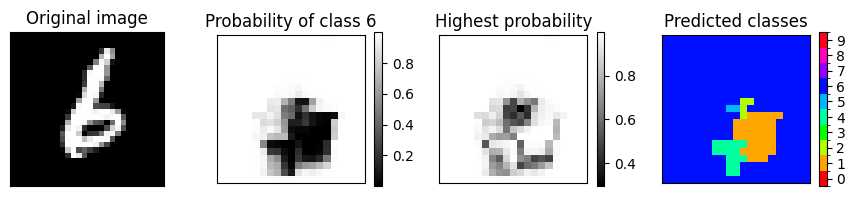

In [233]:
# Fix the seeds
SEED = 1192296
torch.manual_seed(SEED)
np.random.seed(SEED)

# Search 6
image, label = search_digit(6, model, train_loader)
image = image.unsqueeze(0).to('cuda')
label = label.to('cuda')

# There are 21x21 valid positions for 8x8 black patches (28-8+1=21)
# Let us create a list of all patched images
patched_images = []
for i in range(21):
    for j in range(21):
        new_image = image.clone()
        new_image[:,:,i:i+8,j:j+8] = -1 # MNIST is normalized between -1 and 1
        patched_images.append(new_image)

# Classify the patched images
predicted_classes = []
probability_of_class_6 = []
highest_probability = []

for img in patched_images:
    with torch.no_grad():
        predicted = model(img)
        predicted_classes.append(int(torch.argmax(predicted, 1)))
        probability_of_class_6.append(float(torch.nn.functional.softmax(predicted, 1)[0,6]))
        highest_probability.append(float(torch.max(torch.nn.functional.softmax(predicted, 1), 1)[0]))

# Reshape the list to 21x21 and plot
predicted_classes = np.array(predicted_classes).reshape(21,21)
probability_of_class_6 = np.array(probability_of_class_6).reshape(21,21)
highest_probability = np.array(highest_probability).reshape(21,21)

fig, ax = plt.subplots(1, 4, figsize=(11,2))

# Define CMAP
CMAP = 'gray'

# plot the original image
ax[0].imshow(image[0, 0].detach().cpu().numpy(), cmap=CMAP)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Original image')

# Plot the probability of class 6
im0 = ax[1].imshow(probability_of_class_6, cmap=CMAP)
fig.colorbar(im0, ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Probability of class 6')

# Plot the highest probability
im1 = ax[2].imshow(highest_probability, cmap=CMAP)
fig.colorbar(im1, ax=ax[2])
ax[2].set_xticks([])
ax[2].set_yticks([]) 
ax[2].set_title('Highest probability')

import matplotlib.colors as colors
# Plot the predicted classes
boundaries = np.arange(-0.5, 10, 1)  # Start a little before 0 and end a little after 9
cmap = plt.cm.get_cmap('hsv', len(boundaries) - 1) 
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
im2 = ax[3].imshow(predicted_classes, cmap=cmap, norm=norm)
cbar = fig.colorbar(im2, ax=ax[3], ticks=np.arange(0, 10), boundaries=boundaries)
cbar.ax.set_yticklabels(np.arange(0, 10))  # Set tick labels to be integers
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_title('Predicted classes')

plt.savefig('P3_1.eps', format='eps')
plt.show()

4


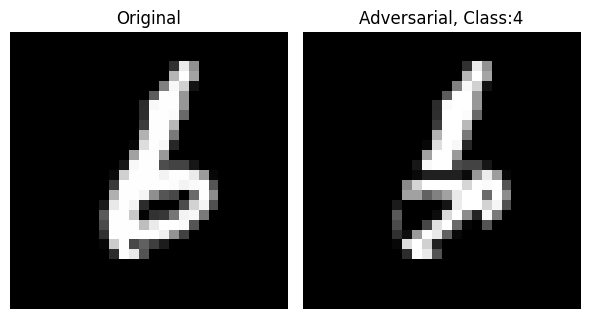

In [310]:
# Creating the adversarial image by patching the original image by anoher digit
image_ad, label_ad = search_digit(2, model, train_loader)
image_ad = image_ad.unsqueeze(0).to('cuda')

# Create the adversarial image
adversarial_image = image.clone()
adversarial_image[:,:,14:22,10:18] = image_ad[:,:,14:22,10:18]

# Classify the adversarial image
with torch.no_grad():
    predicted = model(adversarial_image)
    predicted_class = int(torch.argmax(predicted, 1))
print(predicted_class)

# Plot the original and adversarial images
fig, axes = plt.subplots(1, 2, figsize=(6,6))
for i, ax in enumerate(axes):
    ax.axis('off')
    if i == 0:
        ax.set_title('Original', fontsize=12)
        ax.imshow(image[0, 0].detach().cpu().numpy(), cmap='gray')
    else:
        ax.set_title(f'Adversarial, Class:{predicted_class}', fontsize=12)
        ax.imshow(adversarial_image[0, 0].detach().cpu().numpy(), cmap='gray')
plt.tight_layout()
#plt.savefig('adversarial_image.eps', format='eps')

# Recuurent NN

In [318]:
import numpy as np
import scipy.special as sps

x = np.zeros((3,2))
x[0] = np.array([1.,0.])
x[1] = np.array([0.5,0.25])
x[2] = np.array([0.,1.])
b = np.array([-1.,1.])
c = np.array([0.5,-0.5])
W = np.array([[1.,-1.],[0.,2.]])
U = np.array([[-1.,0.],[1.,-2.]])
V = np.array([[-2.,1.],[-1.,0.]])

def forward_prop(x, W, U, V, b, c, tau):
    h = np.zeros((tau,2))
    y = np.zeros((tau,2))
    for t in range(tau):
        if t == 0:
            h[t] = np.tanh(b + np.dot(U,x[t]))
        else:
            h[t] = np.tanh(b + np.dot(W,h[t-1]) + np.dot(U,x[t]))
        y[t] = sps.softmax(np.dot(V,h[t]) + c)
    loss = (y[tau-1][1] - 0.25)**2 - np.log(y[tau-1][0])
    return loss, y

loss, y = forward_prop(x, W, U, V, b, c, 3)
print(loss)
print(y[0], y[1], y[2])

0.09796771659419912
[0.94921601 0.05078399] [0.95221995 0.04778005] [0.94001124 0.05998876]


In [320]:
# Estimate the gradient wrt b using central differences
eps = 0.000025
grad_b = np.zeros(2)
for i in range(2):
    b[i] += eps
    loss_plus, y = forward_prop(x, W, U, V, b, c, 3)
    b[i] -= 2*eps
    loss_minus, y = forward_prop(x, W, U, V, b, c, 3)
    grad_b[i] = (loss_plus - loss_minus)/(2*eps)
    b[i] += eps
print(grad_b)

[ 0.00038813 -0.01691036]
